In [1]:
import backtrader as bt
import pandas as pd
import pickle
import numpy as np
with open('rf_model_China.pkl', 'rb') as f:
    rf_bundle = pickle.load(f)
model = rf_bundle["model"]
features = rf_bundle["features"]
macro_df = rf_bundle["macro_df"]

In [2]:
macro_df.replace([np.inf, -np.inf], np.nan, inplace=True)
macro_df.dropna(inplace=True)

## 加载回测资产序列数据

In [3]:
# tickers = {
#         "510210.SH": 'stock', # 上证指数ETF
#         "511010.SH": 'bond', # 国债ETF
#         '511880.SH': 'cash', # 银华日利ETF
#         "510170.SH": 'gsci', # 大宗商品ETF
#         '518880.SH': 'gold', # 黄金ETF
#     }

In [4]:
# import yfinance as yf
#
# tickers = {
#     'SPY': 'stock',
#     'IEF': 'bond',
#     'SHY': 'cash',
#     'GSG': 'gsci',
#     'IAU': 'gold',
# }
#
# for ticker, label in tickers.items():
#     ticker = yf.Ticker(ticker)
#     data = ticker.history(period="15y", interval="1d")
#     # 重置索引，将DatetimeIndex变成普通的“Date”列
#     data.reset_index(inplace=True)
#     # 将Date列转换成所需格式（YYYY-MM-DD）
#     data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
#     data.set_index('Date', inplace=True)
#     data.to_csv(f"{label}.csv")

# ==== 加载 CSV 数据 ====
# def load_data(filepath):
#     return bt.feeds.GenericCSVData(
#         dataname=filepath,
#         dtformat="%Y-%m-%d",
#         datetime=0,
#         open=1,
#         high=2,
#         low=3,
#         close=4,
#         volume=6,
#         openinterest=-1
#     )
#
# data_dict = {
#     "stock": load_data("stock.csv"),
#     "bond": load_data("bond.csv"),
#     "cash": load_data("cash.csv"),
#     "gsci": load_data("gsci.csv"),
#     "gold": load_data("gold.csv"),
# }

In [5]:
from openpyxl import load_workbook
from pathlib import Path
from typing import Union, Sequence, Dict

def read_wind_xlsx(
    files: Union[str, Path, Sequence[Union[str, Path]]],
    sheet: str = "Sheet1",
    date_label: str = "Date",
    header_keyword: str = "Date"   # 用来识别英文表头所在行
) -> Union[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    读取 Wind 导出的价格类 Excel，并整理成规范形态：
      ▸ 自动找到首列出现 `header_keyword` 的那一行作为表头
      ▸ 删掉其之前的所有行
      ▸ 将 `date_label` 设为索引并按日期排序
      ▸ 统一把 0 / '0' / '0.0' → NaN

    参数
    ----
    files : str | Path | list[str | Path]
    sheet : str                Excel 工作表名，默认 "Sheet1"
    date_label : str           表头中日期列名称（输出也保持该名字）
    header_keyword : str       用于识别英文表头所在行，默认 "Date"
    """
    def _read_one(path: Union[str, Path]) -> pd.DataFrame:
        wb = load_workbook(path, data_only=True)
        if sheet not in wb.sheetnames:
            raise ValueError(f"'{sheet}' not found in {path}")
        ws = wb[sheet]
        raw = pd.DataFrame(ws.values)

        # ---------- 1️⃣ 识别英文表头行 ----------
        try:
            header_idx = raw.index[raw.iloc[:, 0] == header_keyword][0]
        except IndexError:
            raise ValueError(
                f"无法在 {path} 的 '{sheet}' 中找到以 '{header_keyword}' 为首列的表头行"
            )

        # ---------- 2️⃣ 重新切片并设表头 ----------
        df = raw.iloc[header_idx:].reset_index(drop=True)
        df.columns = df.iloc[0]        # 英文表头
        df = df.iloc[1:].reset_index(drop=True)

        # ---------- 3️⃣ 标准清洗 ----------
        # 3a. 日期列改名并设为索引
        df.rename(columns={df.columns[0]: date_label}, inplace=True)
        df[date_label] = pd.to_datetime(df[date_label])
        df = df.set_index(date_label).sort_index()

        # 3b. 0 / '0' / '0.0' → NaN
        df.replace({0: np.nan, "0": np.nan, "0.0": np.nan}, inplace=True)
        df.infer_objects(copy=False)

        # 3c. 如果出现完全空列，直接删掉（可选）
        df.dropna(axis=1, how="all", inplace=True)

        return df

    # 支持一次性读取多个文件
    if isinstance(files, (list, tuple, set)):
        return {Path(p).stem: _read_one(p) for p in files}
    return _read_one(files)

In [6]:
# # ① 读取单个文件
# df_stock = read_wind_xlsx("stock.xlsx")
# df_stock
# # ② 一次性读取多个文件
# file_list = ["Data_Test.xlsx", "Data_Other.xlsx", "Data_Third.xlsx"]
# dfs = read_wind_xlsx(file_list)

In [7]:
def load_xlsx(filepath, cols_map=None):
    import datetime

    # 默认的“原→标准”列名映射
    default_map = dict(open='open', high='high',
                       low='low', close='close', volume='volume')
    if cols_map is not None:
        default_map.update(cols_map)

    df = read_wind_xlsx(filepath)

    # 统一列名到首字母大写格式
    df = df.rename(columns={
        default_map['open']:   'Open',
        default_map['high']:   'High',
        default_map['low']:    'Low',
        default_map['close']:  'Close',
        default_map['volume']: 'Volume'
    })

    # 确保索引是真正的 DatetimeIndex
    df.index = pd.to_datetime(df.index)
    # 只保留需要的 5 列
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

    # 回传 Backtrader 数据源
    return bt.feeds.PandasData(
        dataname=df,           # 索引就是 datetime
        fromdate = datetime.datetime(2014,1,1),
        todate = datetime.datetime(2025,7,1),  # 回测时间范围
        datetime=None,         # 告诉 Backtrader “已用索引”
        open='Open', high='High',
        low='Low', close='Close',
        volume='Volume',
        openinterest=None
    )
data_dict = {
    "stock": load_xlsx("stock.xlsx"),
    "bond" : load_xlsx("bond.xlsx"),
    "cash" : load_xlsx("cash.xlsx"),
    "gsci" : load_xlsx("gsci.xlsx"),
    "gold" : load_xlsx("gold.xlsx"),
}

/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({0: np.nan, "0": np.nan, "0.0": np.nan}, inplace=True)
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({0: np.nan, "0": np.nan, "0.0": np.nan}, inplace=True)
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated 

## 单目标随机森林策略

In [8]:
class MacroDynamicStrategy(bt.Strategy):
    """
    • 依据随机森林 **预测概率** 连续调整权重：
        risk = P(target=1)   ∈ [0,1]
        stock_w = 0.6 ­– 0.4·risk         （0.6 → 0.2）
        bond_w  = 0.4 + 0.1·risk         （0.4 → 0.5）
        cash_w  = 0.00+ 0.10·risk        （0.0 → 0.1）
        gsci_w  = 0.00+ 0.10·risk        （0.0 → 0.1）
        gold_w  = 1 - (stock_w + bond_w + cash_w + gsci_w)  （剩余权重）
    • 每月仅调仓一次；若本月 risk 与上月差 < 5 pct 则不调，以减少换手。
    """
    params = dict(
        rf_model   = model,
        features   = features,
        macro_df   = macro_df,
        min_delta  = 0.01        # 调仓阈值
    )

    def __init__(self):
        mdf = self.p.rf_model["macro_df"].copy()
        mdf.index = pd.to_datetime(mdf.index).date
        self.macro_df  = mdf
        self.model     = self.p.rf_model["model"]
        self.features  = self.p.rf_model["features"]

        self.last_risk = None       # 上次风险概率
        self.last_month = None

        self.data_map = {
            "stock": self.datas[0],
            "bond":  self.datas[1],
            "cash":  self.datas[2],
            "gsci":  self.datas[3],
            "gold":  self.datas[4],
        }
        self.portfolio_value = []
    def start(self):
        # 一启动就先持 60/40，让收益序列有波动
        total = self.broker.getvalue()
        self.buy(data=self.data_map['stock'],
                 size=0.6 * total / self.data_map['stock'].close[0])
        self.buy(data=self.data_map['bond'],
                 size=0.4 * total / self.data_map['bond'].close[0])

    # -------- 月度调仓逻辑 --------------------------------------------------
    def next(self):
        dt = self.data.datetime.date(0)
        self.portfolio_value.append({'date': dt,
                                     'value': self.broker.getvalue()})

        # 仅每月首个交易日运行调仓
        curr_month = dt.replace(day=1)
        if self.last_month == curr_month:
            return
        self.last_month = curr_month

        # 宏观数据可用性检查
        if dt < self.macro_df.index.min():
            return
        row = self.macro_df.loc[:dt].iloc[-1]
        X = row[self.features].values.reshape(1, -1)
        # -------- 提取 P(target=1) – 安全写法 -----------------
        probas   = self.model.predict_proba(X)[0]          # 概率向量
        cls_prob = dict(zip(self.model.classes_, probas))  # 映射 {class: proba}
        proba_1  = cls_prob.get(1, 0.0)                    # 若类 1 不存在 => 0


        # 若风险概率变化不大，则跳过调仓
        if self.last_risk is not None and abs(proba_1 - self.last_risk) < self.p.min_delta:
            return
        self.last_risk = proba_1

        # ---------------- 权重公式 ----------------
        w_stock = 0.6 - 0.4 * proba_1
        w_bond  = 0.4 + 0.1 * proba_1
        w_cash  = 0.0 + 0.1 * proba_1
        w_gsci  = 0.0 + 0.1 * proba_1
        w_gold  = max(0, 1 - (w_stock + w_bond + w_cash + w_gsci))  # 保证权重和为 1

        alloc = dict(stock=w_stock, bond=w_bond, cash=w_cash,
                     gsci=w_gsci, gold=w_gold)

        # ---------------- 执行调仓 ----------------
        for d in self.datas:
            if self.getposition(d).size:
                self.close(d)

        total_val = self.broker.getvalue()
        for asset, weight in alloc.items():
            if weight <= 0:
                continue
            datafeed = self.data_map[asset]
            size = (total_val * weight) / datafeed.close[0]
            if size > 0:
                self.buy(data=datafeed, size=size)

    # -------- 结束时输出净值 ----------------------------------------------
    def stop(self):
        pv = pd.DataFrame(self.portfolio_value).set_index('date')
        pv['cum_return'] = pv['value'] / pv['value'].iloc[0]
        self.pv_df = pv

In [9]:
# ==== Cerebro 回测 ====
cerebro = bt.Cerebro()
# 添加分析器
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.01)

# 加入数据
for key in ["stock", "bond", "cash", "gsci", "gold"]:
    cerebro.adddata(data_dict[key])
cerebro.addstrategy(MacroDynamicStrategy, rf_model=rf_bundle)

# 设置起始资金
cerebro.broker.setcash(1_000_000)

results = cerebro.run()
# 获取回测结果
strat = results[0]
# 获取最大回撤
drawdown = strat.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {drawdown['max']['drawdown']}")
# 获取收益率
returns = strat.analyzers.returns.get_analysis()
print(f"Annual Return: {returns['rnorm100']:.2f}%")
# 获取夏普比率
sharpe = strat.analyzers.sharpe.get_analysis()
print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
# 获取最终资产价值
final_value = cerebro.broker.getvalue()
print(f"Final Portfolio Value: {final_value:.2f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493:

Max Drawdown: 25.325754677350787
Annual Return: 6.76%
Sharpe Ratio: 0.59
Final Portfolio Value: 2065264.79


## 双目标随机森林策略

In [10]:
class DualMacroStrategy(bt.Strategy):
    """
    • 基于两个模型预测：
        risk_proba   = 风险概率 P(drawdown)
        return_proba = 收益概率 P(upward)

    • 连续映射方式调整权重：
        stock_w = 0.3 + 0.3·return_proba - 0.3·risk_proba     （最多 0.6，最少 0.0）
        bond_w  = 0.5 - 0.2·return_proba + 0.2·risk_proba     （偏防守）
        cash_w  = 0.0 + 0.1·risk_proba                        （补安全边际）
        gsci_w  = 0.0 + 0.1·return_proba                      （偏周期进攻）
        gold_w  = 剩余部分补满                                （抗通胀）

    • 每月仅调仓一次；若两者变化均 < 0.01 则不调。
    """
    params = dict(
        rf_bundle   = None,      # dual_rf_bundle
        min_delta   = 0.05  # 调仓阈值（风险和收益概率变化小于此值则不调仓）
    )

    def __init__(self):
        bundle = self.p.rf_bundle
        self.risk_model   = bundle["risk_model"]
        self.return_model = bundle["return_model"]
        self.features     = bundle["features"]
        self.macro_df     = bundle["macro_df"].copy()
        self.macro_df.index = pd.to_datetime(self.macro_df.index).date

        self.last_month = None
        self.last_risk = None
        self.last_return = None

        self.data_map = {
            "stock": self.datas[0],
            "bond":  self.datas[1],
            "cash":  self.datas[2],
            "gsci":  self.datas[3],
            "gold":  self.datas[4],
        }

        self.portfolio_value = []

    def start(self):
        total = self.broker.getvalue()
        self.buy(data=self.data_map['stock'],
                 size=0.6 * total / self.data_map['stock'].close[0])
        self.buy(data=self.data_map['bond'],
                 size=0.4 * total / self.data_map['bond'].close[0])

    def next(self):
        dt = self.data.datetime.date(0)
        self.portfolio_value.append({'date': dt, 'value': self.broker.getvalue()})

        curr_month = dt.replace(day=1)
        if self.last_month == curr_month:
            return
        self.last_month = curr_month

        if dt < self.macro_df.index.min():
            return
        row = self.macro_df.loc[:dt].iloc[-1]
        X = row[self.features].values.reshape(1, -1)

        risk_proba   = self.risk_model.predict_proba(X)[0][1]
        return_proba = self.return_model.predict_proba(X)[0][1]

        # 不调仓条件：信号变化小
        if (self.last_risk is not None and abs(risk_proba - self.last_risk) < self.p.min_delta and
            self.last_return is not None and abs(return_proba - self.last_return) < self.p.min_delta):
            return

        self.last_risk = risk_proba
        self.last_return = return_proba

        # 连续型权重分配逻辑
        w_stock = max(0, min(0.6, 0.3 + 0.3 * return_proba - 0.3 * risk_proba))
        w_bond  = max(0, min(0.6, 0.5 - 0.2 * return_proba + 0.2 * risk_proba))
        w_cash  = 0.1 * risk_proba
        w_gsci  = 0.1 * return_proba
        w_gold  = max(0, 1 - (w_stock + w_bond + w_cash + w_gsci))

        alloc = dict(stock=w_stock, bond=w_bond, cash=w_cash, gsci=w_gsci, gold=w_gold)

        for d in self.datas:
            if self.getposition(d).size:
                self.close(d)

        total_val = self.broker.getvalue()
        for asset, weight in alloc.items():
            if weight <= 0:
                continue
            datafeed = self.data_map[asset]
            size = (total_val * weight) / datafeed.close[0]
            self.buy(data=datafeed, size=size)

    def stop(self):
        pv = pd.DataFrame(self.portfolio_value).set_index('date')
        pv['cum_return'] = pv['value'] / pv['value'].iloc[0]
        self.pv_df = pv
# 开始回测
import pickle
with open("dual_rf_bundle.pkl", "rb") as f:
    dual_rf_bundle = pickle.load(f)

cerebro = bt.Cerebro()
# 添加分析器
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.01)

# 加入数据
for key in ["stock", "bond", "cash", "gsci", "gold"]:
    cerebro.adddata(data_dict[key])
cerebro.addstrategy(DualMacroStrategy, rf_bundle=dual_rf_bundle)

# 设置起始资金
cerebro.broker.setcash(1_000_000)

results = cerebro.run()
# 获取回测结果
dual_strat = results[0]
# 获取最大回撤
drawdown = dual_strat.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {drawdown['max']['drawdown']}")
# 获取收益率
returns = dual_strat.analyzers.returns.get_analysis()
print(f"Annual Return: {returns['rnorm100']:.2f}%")
# 获取夏普比率
sharpe = dual_strat.analyzers.sharpe.get_analysis()
print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
# 获取最终资产价值
final_value = cerebro.broker.getvalue()
print(f"Final Portfolio Value: {final_value:.2f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493:

Max Drawdown: 14.697734766777263
Annual Return: 6.92%
Sharpe Ratio: 0.77
Final Portfolio Value: 2098842.94


## 与基准策略对比

In [11]:
class BuyHoldExitStrategy(bt.Strategy):
    """
    ▸ 第 1 根 K 线 **开盘** 按权重一次性建仓
    ▸ 期间不调仓
    ▸ 回测结束平仓并输出净值曲线
    """
    params = dict(
        alloc=dict(stock=0.6, bond=0.4, cash=0.0, gsci=0.0, gold=0.0)
    )

    def __init__(self):
        self.data_map = {
            "stock": self.datas[0],
            "bond":  self.datas[1],
            "cash":  self.datas[2],
            "gsci":  self.datas[3],
            "gold":  self.datas[4],
        }
        self.pv_records = []      # 储存每日净值
        self.first_bar_done = False

    def next(self):
        # —— 1️⃣ 记录前一天收盘后（即今日开盘前）的组合价值 ——
        dt = self.data.datetime.date(0)
        self.pv_records.append(
            {'date': dt, 'value': self.broker.getvalue()}
        )

        # —— 2️⃣ 只在第一根 K 线的 **开盘** 建仓 ——
        if not self.first_bar_done:
            for asset, weight in self.p.alloc.items():
                if weight <= 0:
                    continue
                d = self.data_map[asset]
                price = d.open[0]          # 用开盘价估算下单量
                if np.isnan(price) or price == 0:
                    continue              # 避开空值行
                cash = self.broker.getvalue() * weight
                size = int(cash // price) # 取整份额
                if size > 0:
                    self.buy(data=d, size=size)
            self.first_bar_done = True

    def stop(self):
        # —— 3️⃣ 输出净值 DataFrame + 累计收益 ——
        pv_df = pd.DataFrame(self.pv_records).set_index('date')
        pv_df['cum_return'] = pv_df['value'] / pv_df['value'].iloc[0]
        self.pv_df = pv_df

In [12]:
# ==== Cerebro 回测 ====
cerebro = bt.Cerebro()
# 添加分析器
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.01)


# 加入数据
for key in ["stock", "bond", "cash", "gsci", "gold"]:
    cerebro.adddata(data_dict[key])
cerebro.addstrategy(BuyHoldExitStrategy)

# 设置起始资金
cerebro.broker.setcash(1_000_000)

results = cerebro.run()
# 获取回测结果
bench = results[0]
# 获取最大回撤
drawdown = bench.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {drawdown['max']['drawdown']}")
# 获取收益率
returns = bench.analyzers.returns.get_analysis()
print(f"Annual Return: {returns['rnorm100']:.2f}%")
# 获取夏普比率
sharpe = bench.analyzers.sharpe.get_analysis()
print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
# 获取最终资产价值
final_value = cerebro.broker.getvalue()
print(f"Final Portfolio Value: {final_value:.2f}")

Max Drawdown: 37.3219322355561
Annual Return: 5.64%
Sharpe Ratio: 0.39
Final Portfolio Value: 1837869.05


## 绘图

/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({0: np.nan, "0": np.nan, "0.0": np.nan}, inplace=True)
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({0: np.nan, "0": np.nan, "0.0": np.nan}, inplace=True)
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated 

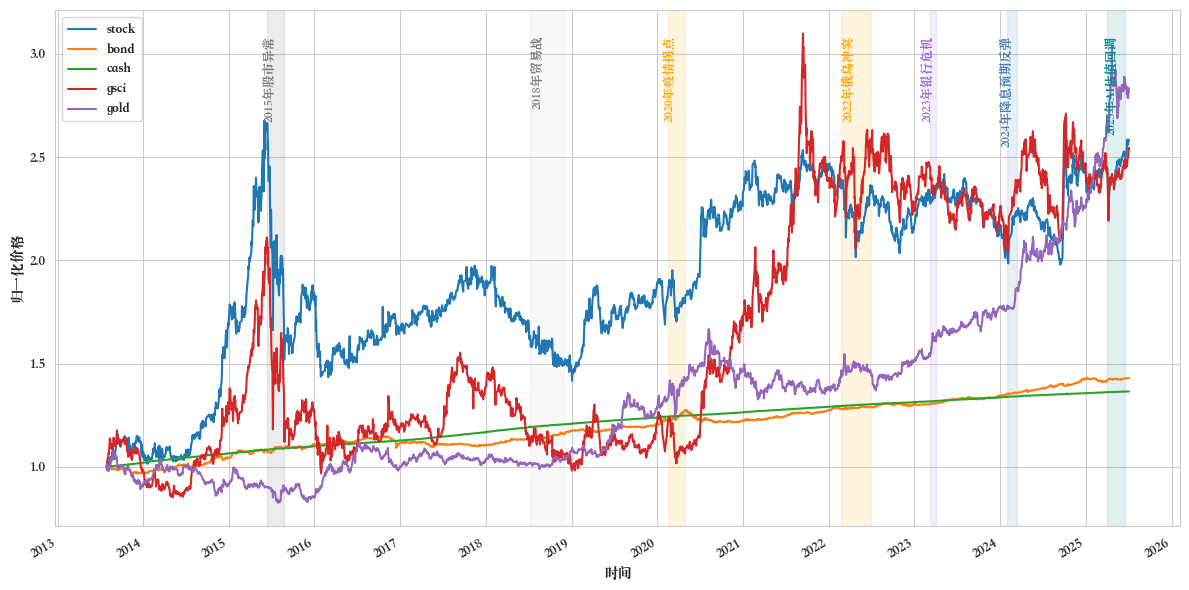

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.sans-serif'] = ['Songti SC']  # 中文支持
plt.rcParams['axes.unicode_minus'] = False       # 负号显示

# 1. 读取 CSV 并提取 date 和 Close 列（适配你的格式）
def load_close_series(asset_name):
    df = read_wind_xlsx(f"{asset_name}.xlsx")
    # df = pd.read_csv(f"{asset_name}.csv", parse_dates=['Date'])
    return df['close'].rename(asset_name)

# 2. 合并多个资产的收盘价序列
assets = ['stock', 'bond', 'cash', 'gsci', 'gold']
price_df = pd.concat([load_close_series(name) for name in assets], axis=1).dropna()

# 3. 归一化净值
normalized_prices = price_df / price_df.iloc[0]

# 4. 绘图
ax = normalized_prices.plot(figsize=(12, 6))
ax.xaxis.set_major_locator(mdates.YearLocator())         # 间隔 1 年
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # 显示四位年份

# === 重大事件区间（根据公开新闻时间线细化）=========================
# 1) 2015 A 股异常暴跌：6 · 12 最高点→ 8 · 26 阶段底
ax.axvspan(pd.Timestamp('2015-06-12'), pd.Timestamp('2015-08-26'),
           color='grey', alpha=0.15)
ax.text(pd.Timestamp('2015-07-15'), 0.95, "2015年股市异常",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='grey')

# 2) 2018 中美贸易战：首轮关税生效 7 · 6 → 加征 10%/2000 亿 9 · 24
ax.axvspan(pd.Timestamp('2018-07-06'), pd.Timestamp('2018-12-01'),
           color='lightgrey', alpha=0.15)
ax.text(pd.Timestamp('2018-09-01'), 0.95, "2018年贸易战",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='grey')

# 3) 2020 新冠全球扩散：WHO 公布 PHEIC 后全球抛售 2 · 15 → 4 · 30
ax.axvspan(pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-30'),
           color='orange', alpha=0.12)
ax.text(pd.Timestamp('2020-03-15'), 0.95, "2020年疫情拐点",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='orange')

# 4) 2022 俄乌冲突：开战 2 · 24 → 大宗商品高点 7 · 01 前后
ax.axvspan(pd.Timestamp('2022-02-24'), pd.Timestamp('2022-07-01'),
           color='orange', alpha=0.12)
ax.text(pd.Timestamp('2022-04-15'), 0.95, "2022年俄乌冲突",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='orange')

# 5) 2023 银行业动荡（SVB/CS）：SVB 暴雷 3 · 08 → 市场企稳 4 · 05
ax.axvspan(pd.Timestamp('2023-03-08'), pd.Timestamp('2023-04-05'),
           color='mediumpurple', alpha=0.12)
ax.text(pd.Timestamp('2023-03-20'), 0.95, "2023年银行危机",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='mediumpurple')
# 6) 2024 年美联储首次降息预期——市场大幅反弹
ax.axvspan(pd.Timestamp('2024-01-30'), pd.Timestamp('2024-03-15'),
           color='steelblue', alpha=0.12)
ax.text(pd.Timestamp('2024-02-20'), 0.95, "2024年降息预期反弹",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='steelblue')

# 7) 2025 年 AI 主题高位回撤／估值调整
ax.axvspan(pd.Timestamp('2025-04-01'), pd.Timestamp('2025-06-15'),
           color='darkcyan', alpha=0.12)
ax.text(pd.Timestamp('2025-05-10'), 0.95, "2025年AI估值回调",
        transform=ax.get_xaxis_transform(),
        rotation=90, va='top', ha='right', fontsize=9, color='darkcyan')
# plt.title("图6.1 多资产历史净值对比（归一化）")
plt.xlabel("时间")
plt.ylabel("归一化价格")
plt.grid(True)
plt.tight_layout()
plt.show()

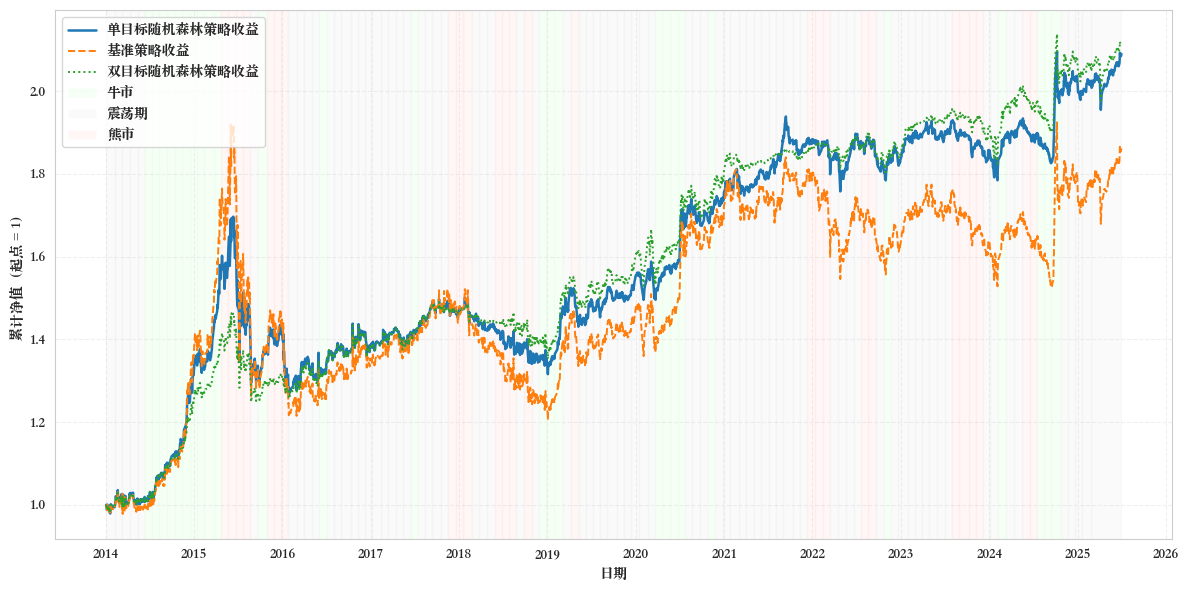

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === 1. 准备净值序列 ==========================
strategy_nav   = strat.pv_df['cum_return']
dual_strategy_nav = dual_strat.pv_df['cum_return']  # 双目标策略净值
benchmark_nav  = bench.pv_df['cum_return']      # “基准策略”净值

# 确保索引对齐、日期格式一致
strategy_nav.index  = pd.to_datetime(strategy_nav.index)
benchmark_nav.index = pd.to_datetime(benchmark_nav.index)
dual_strategy_nav.index = pd.to_datetime(dual_strategy_nav.index)

strategy_nav, benchmark_nav = strategy_nav.align(benchmark_nav, join='inner')
dual_strategy_nav, benchmark_nav = dual_strategy_nav.align(benchmark_nav, join='inner')

# -------------------------------------------------------------------------
# 判定阈值；过小的浮点误差不会被误判
tol = 1e-8

# 1) 先把 0 替换为 NaN（若有），再去掉缺失值
strategy_nav  = strategy_nav.replace(0, np.nan).dropna()
benchmark_nav = benchmark_nav.replace(0, np.nan).dropna()
dual_strategy_nav = dual_strategy_nav.replace(0, np.nan).dropna()

# 2) 找到策略净值首次出现显著变化的位置
first_valid_idx = strategy_nav.loc[strategy_nav.diff().abs() > tol] \
                              .first_valid_index()

# 3) 截断三条净值序列
strategy_nav  = strategy_nav.loc[first_valid_idx:]
benchmark_nav = benchmark_nav.loc[first_valid_idx:]
dual_strategy_nav = dual_strategy_nav.loc[first_valid_idx:]
# -------------------------------------------------------------------------

# === 2. 滚动窗口计算区间收益 ==================================================
window = 63   # 半年或一季 63 交易日
step   = 21   # 每月滚动
dates  = strategy_nav.index

records = []
for i in range(0, len(dates) - window, step):
    start = dates[i]
    end   = dates[i + window]

    strat_ret = strategy_nav.loc[end]   / strategy_nav.loc[start]   - 1
    bench_ret = benchmark_nav.loc[end]  / benchmark_nav.loc[start]  - 1
    dual_strat_ret = dual_strategy_nav.loc[end] / dual_strategy_nav.loc[start] - 1

    records.append({
        'start': start, 'end': end,
        '单目标随机森林策略收益': strat_ret,
        '双目标随机森林策略收益': dual_strat_ret,
        '基准收益': bench_ret
    })

df_rolling = pd.DataFrame(records)

# === 3. 用“基准收益”划分市场阶段（熊市/震荡/牛市） ==========================
df_rolling['市场阶段'] = pd.qcut(
    df_rolling['基准收益'],
    q=[0, 0.2, 0.8, 1.0],
    labels=['熊市', '震荡期', '牛市']
)

# ---------- 绘图 ------------------------------------------------------------
# 0) 先把两条净值曲线归一化到 1
combo = pd.concat([strategy_nav, benchmark_nav, dual_strategy_nav],
                  axis=1, keys=['strat', 'bench', 'dual_strat']).dropna()
strategy_line  = combo['strat'] / combo['strat'].iloc[0]
dual_strategy_line = combo['dual_strat'] / combo['dual_strat'].iloc[0]
benchmark_line = combo['bench'] / combo['bench'].iloc[0]

# 1) 生成非重叠的阶段区间
df_stage = df_rolling[['start', '市场阶段']].sort_values('start').reset_index(drop=True)
df_stage['end'] = df_stage['start'].shift(-1).fillna(strategy_line.index[-1])

# 2) 颜色映射
stage_color = {
    '熊市':  '#ffe6e6',
    '震荡期': '#f2f2f2',
    '牛市':  '#e6ffe6'
}

# 3) 画图
fig, ax = plt.subplots(figsize=(12, 6))

# 背景着色
for _, row in df_stage.iterrows():
    ax.axvspan(row['start'], row['end'],
               color=stage_color[row['市场阶段']],
               alpha=0.35, zorder=0)

# 净值折线
ax.plot(strategy_line,  label='单目标随机森林策略收益',  linewidth=1.8)
ax.plot(benchmark_line, label='基准策略收益', linewidth=1.4, linestyle='--')
ax.plot(dual_strategy_line, label='双目标随机森林策略收益', linewidth=1.4, linestyle=':')
ax.xaxis.set_major_locator(mdates.YearLocator())         # 间隔 1 年
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # 显示四位年份

# 美化
ax.set_xlabel("日期")
ax.set_ylabel("累计净值（起点 = 1）")
ax.grid(True, which='both', linestyle='--', alpha=0.3)

# 构造背景色图例
bg_handles = [mpatches.Patch(facecolor=stage_color[s], alpha=0.35, label=s)
              for s in ['牛市', '震荡期', '熊市']]
plt.legend(handles=[*ax.lines, *bg_handles], loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
from pathlib import Path

# -------- ① 最大回撤 ----------
def max_drawdown(nav):
    cum_max = nav.cummax()
    return (nav / cum_max - 1).min()     # 已经是负数

# -------- ② 统一计算六项指标，返回 dict --------------------------
def _calc_metrics(nav_slice, ret_slice, rf, freq, annualized=True):
    """
    annualized=True 时返回年化收益，否则返回累计收益
    """
    cum_ret = nav_slice.iloc[-1] / nav_slice.iloc[0] - 1
    if annualized:
        years = len(nav_slice) / freq          # 交易日→年数
        ann_ret = (1 + cum_ret) ** (1 / years) - 1
    else:
        ann_ret = cum_ret

    ann_vol  = ret_slice.std() * np.sqrt(freq)
    mdd      = max_drawdown(nav_slice)
    sharpe   = (ret_slice.mean() - rf / freq) / ret_slice.std() * np.sqrt(freq)
    down_std = ret_slice[ret_slice < 0].std()
    sortino  = (ret_slice.mean() * freq) / (down_std * np.sqrt(freq))
    calmar   = ann_ret / (-mdd) if mdd < 0 else np.nan

    return dict(
        年化收益   = ann_ret,
        年化波动   = ann_vol,
        最大回撤   = mdd,
        Sharpe   = sharpe,
        Calmar   = calmar,
        Sortino  = sortino
    )

# -------- ③ 返回含 Total 行的年度表 --------------------------------
def stats_table(nav, rf=0.0, freq=252):
    nav = nav.sort_index()
    ret = nav.pct_change().dropna()

    out = {}
    for yr, nav_y in nav.groupby(nav.index.year):
        if len(nav_y) < 50:
            continue
        ret_y = ret[ret.index.year == yr]
        out[yr] = _calc_metrics(nav_y, ret_y, rf, freq, annualized=False)

    # 追加总计
    out["汇总"] = _calc_metrics(nav, ret, rf, freq, annualized=True)

    df = pd.DataFrame(out).T
    # 1) 把需要转百分比的列名先存一下
    pct_cols = ["年化收益", "年化波动", "最大回撤"]

    # 2) 百分化
    df[pct_cols] *= 100

    # 3) 给这三列加 “(%)” 后缀，避免再 KeyError
    df = df.rename(columns={c: f"{c}(%)" for c in pct_cols})

    # 4) 按固定顺序返回
    order = ["年化收益(%)", "年化波动(%)", "最大回撤(%)",
             "Sharpe", "Calmar", "Sortino"]
    return df[order].round(2)

# -------- ④ 写入多 Sheet Excel -------------------------------------
nav_dict = {
    "单目标随机森林策略": strategy_nav,
    "双目标随机森林策略": dual_strategy_nav,
    "60-40基准策略":      benchmark_nav
}

with pd.ExcelWriter("年度绩效对比.xlsx", engine="openpyxl") as writer:
    for name, nav in nav_dict.items():
        stats_table(nav).to_excel(writer, sheet_name=name)

print("✔ 已生成 '年度绩效对比.xlsx'：每个策略独立 Sheet，底部含 Total 行。")

✔ 已生成 '年度绩效对比.xlsx'：每个策略独立 Sheet，底部含 Total 行。


## 随机森林模型预测效果

/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/4047073938.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_df.resample('M').last()        # 若本来已是月频，可改成 macro_df.copy()
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/2270972924.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({0: np.nan, "0": np.nan, "0.0": np.nan}, inplace=True)
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_93203/4047073938.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').last()               # 保证月末价格


对数拟合： y = -0.2718 * ln(x) + -0.1643


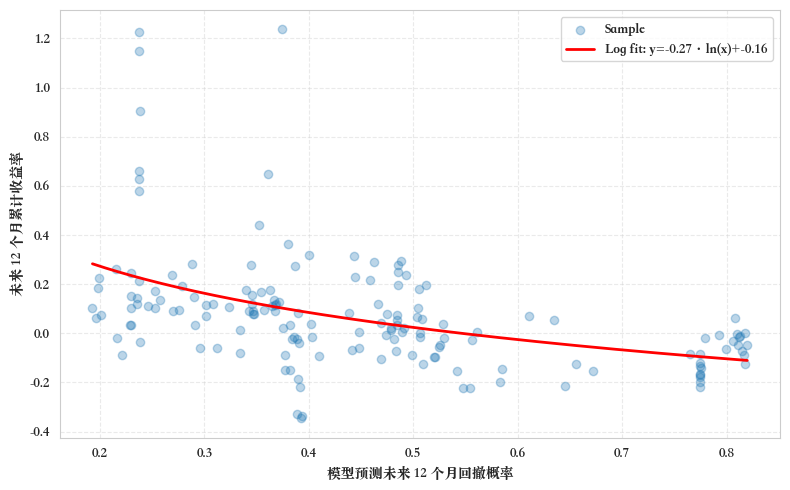

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.exceptions import NotFittedError

# ===============================================================
# 0) 统一索引：全部用「月末」日期做行标签（方便 12m 对齐）
# ---------------------------------------------------------------
# 如果 macro_df 原本是日频，把它先聚合到月末；否则直接复制
macro_df_m = (
    macro_df.resample('M').last()        # 若本来已是月频，可改成 macro_df.copy()
            .copy()
)

# ===============================================================
# 1) 预测“未来 12 个月回撤概率”
# ---------------------------------------------------------------
X_raw   = macro_df_m[features].replace([np.inf, -np.inf], np.nan)
X_clean = X_raw.dropna()
idx_ok  = X_clean.index

try:
    # 模型输出：P( future-drawdown = 1 | 当期特征 )
    pred_prob = model.predict_proba(X_clean)[:, 1]
except NotFittedError:
    raise RuntimeError("模型尚未训练，请先调用 model.fit()")

macro_df_m["pred_prob"] = np.nan
macro_df_m.loc[idx_ok, "pred_prob"] = pred_prob

# ===============================================================
# 2) 计算未来 12 个月累计收益率
# ---------------------------------------------------------------
# a) 读入日线或月线价格并对齐到月末
df_price = read_wind_xlsx('stock.xlsx')
price_m  = (
    df_price['close']
    .resample('M').last()               # 保证月末价格
)

# b) 月度收益率序列并累乘成 12m
#    pct_change(periods=12) 已经 = (P_t / P_{t-12}) - 1
fwd_12m_ret = price_m.pct_change(periods=12).shift(-12)

# 汇入主表
macro_df_m["fwd_12m_return"] = fwd_12m_ret.reindex(macro_df_m.index)

# -----------------------------------------
# 0) 取有效样本并剔除 pred_prob ≤ 0
# -----------------------------------------
valid = macro_df_m[["pred_prob", "fwd_12m_return"]].dropna()
valid = valid[valid['pred_prob'] > 0]          # 只留正值

x = valid['pred_prob'].values
y = valid['fwd_12m_return'].values

# -----------------------------------------
# 1) 最小二乘拟合  y = a * ln(x) + b
# -----------------------------------------
lnx = np.log(x)
a, b = np.polyfit(lnx, y, deg=1)
print(f"对数拟合： y = {a:.4f} * ln(x) + {b:.4f}")

# 拟合曲线（为了画得平滑，生成 200 个 x 点）
x_line = np.linspace(x.min(), x.max(), 200)
y_line = a * np.log(x_line) + b

# -----------------------------------------
# 2) 绘图
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.3, label="Sample")
plt.plot(x_line, y_line, color="red", lw=2,
         label=f"Log fit: y={a:.2f}·ln(x)+{b:.2f}")
plt.xlabel("模型预测未来 12 个月回撤概率")
plt.ylabel("未来 12 个月累计收益率")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()